In [1]:
!mkdir -p /kaggle/working/coco/images

%cd /kaggle/working/coco

!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip

/kaggle/working/coco
--2025-03-07 00:02:37--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.38.241, 52.217.167.225, 16.15.177.81, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.38.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  51.7MB/s    in 5.1s    

2025-03-07 00:02:42 (47.6 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 21.3 MB/s eta 0:00:0000:01


In [ ]:

import json
import os
from tqdm import tqdm

# Paths
coco_annotation_path = "/kaggle/working/coco/annotations/instances_train2017.json"
images_dir = "/kaggle/input/recaptcha-set/Captcha dataset"
labels_dir = "/kaggle/working/coco/yolo_labels"

# Create labels directory
os.makedirs(labels_dir, exist_ok=True)

# Load COCO annotations
with open(coco_annotation_path, "r") as f:
    coco_data = json.load(f)

# Get category mapping
category_mapping = {cat["id"]: cat["name"] for cat in coco_data["categories"]}
class_mapping = {name: idx for idx, name in enumerate(["motorcycle", "bus", "traffic light"])}

# Convert COCO format to YOLO format
image_info = {img["id"]: (img["file_name"], img["width"], img["height"]) for img in coco_data["images"]}

for annotation in tqdm(coco_data["annotations"], desc="Converting annotations"):
    img_id = annotation["image_id"]
    category_id = annotation["category_id"]

    # Skip if category is not in our filtered list
    if category_mapping[category_id] not in class_mapping:
        continue

    # Get image details
    image_file, img_width, img_height = image_info.get(img_id, (None, None, None))
    if image_file is None:
        continue

    # YOLO format: class_id x_center y_center width height (normalized)
    bbox = annotation["bbox"]
    x, y, w, h = bbox

    # ✅ Convert using actual image size
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    w /= img_width
    h /= img_height

    # Save label file
    label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".txt"))
    with open(label_path, "a") as f:
        f.write(f"{class_mapping[category_mapping[category_id]]} {x_center} {y_center} {w} {h}\n")

print("✅ Fixed conversion completed! YOLO labels saved in:", labels_dir)

Converting annotations: 100%|██████████| 860001/860001 [00:01<00:00, 536176.77it/s]

✅ Fixed conversion completed! YOLO labels saved in: /kaggle/working/coco/yolo_labels


In [4]:
ls /kaggle/working/coco/yolo_labels | wc -l

10202


In [5]:
ls /kaggle/input/recaptcha-set/"Captcha dataset" | wc -l

11271


In [6]:
# Create a directory for labeled images (writable)
!mkdir -p /kaggle/working/labeled_images/

# List image filenames (without .jpg extension)
!cd "/kaggle/input/recaptcha-set/Captcha dataset/" && ls | sed 's/.jpg//' | sort > /kaggle/working/image_list.txt

# List label filenames (without .txt extension)
!cd "/kaggle/working/coco/yolo_labels/" && ls | sed 's/.txt//' | sort > /kaggle/working/label_list.txt

# Find images that have corresponding labels
!comm -12 /kaggle/working/image_list.txt /kaggle/working/label_list.txt > /kaggle/working/labeled_images_list.txt

# Copy only images that have corresponding labels to the new directory
!cd "/kaggle/input/recaptcha-set/Captcha dataset/" && cat /kaggle/working/labeled_images_list.txt | xargs -I {} cp {}.jpg /kaggle/working/labeled_images/

!echo "✅ All labeled images have been copied to /kaggle/working/labeled_images/"

✅ All labeled images have been copied to /kaggle/working/labeled_images/


In [7]:
ls /kaggle/working/labeled_images | wc -l

7319


In [23]:
dataset_yaml = """
path: /kaggle/working  # Root directory
train: labeled_images  # Training images directory
val: labeled_images  # Validation images directory

nc: 3  # Number of classes
names: ['motorcycle', 'bus', 'traffic light']

train_labels: coco/yolo_labels  # Path to training labels
val_labels: coco/yolo_labels  # Path to validation labels
"""

with open("/kaggle/working/coco/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("✅ dataset.yaml updated successfully!")

✅ dataset.yaml updated successfully!


In [9]:
ls -l /kaggle/working/coco/yolo_labels | head -10

total 40808
-rw-r--r-- 1 root root  140 Mar  7 00:03 000000000073.txt
-rw-r--r-- 1 root root   68 Mar  7 00:03 000000000086.txt
-rw-r--r-- 1 root root  571 Mar  7 00:03 000000000257.txt
-rw-r--r-- 1 root root   56 Mar  7 00:03 000000000260.txt
-rw-r--r-- 1 root root  196 Mar  7 00:03 000000000359.txt
-rw-r--r-- 1 root root   66 Mar  7 00:03 000000000471.txt
-rw-r--r-- 1 root root   51 Mar  7 00:03 000000000510.txt
-rw-r--r-- 1 root root   61 Mar  7 00:03 000000000529.txt
-rw-r--r-- 1 root root  128 Mar  7 00:03 000000000532.txt
ls: write error: Broken pipe


In [10]:
!ls /kaggle/working/labeled_images/*.jpg 2>/dev/null | while read img; do \
    lbl="/kaggle/working/coco/yolo_labels/$(basename "$img" .jpg).txt"; \
    [ -f "$lbl" ] || echo "Missing label for: $img"; \
done

In [11]:
ls /kaggle/working/coco/yolo_labels | head

000000000073.txt
000000000086.txt
000000000257.txt
000000000260.txt
000000000359.txt
000000000471.txt
000000000510.txt
000000000529.txt
000000000532.txt
000000000540.txt
ls: write error: Broken pipe


In [12]:
!ls /kaggle/working/labeled_images | sed 's/.jpg/.txt/' | sort > images_list.txt
!ls /kaggle/working/coco/yolo_labels | sort > labels_list.txt
!comm -23 images_list.txt labels_list.txt

In [13]:
!cp -r /kaggle/working/coco/yolo_labels/* /kaggle/working/labeled_images/

In [14]:
import os

train_path = "/kaggle/working/labeled_images"  # Adjust if needed

# Count images
num_images = len(os.listdir(train_path))
print(f"Total images in dataset: {num_images}")

Total images in dataset: 17521


In [15]:
import glob

labels_path = "/kaggle/working/labeled_images"  # Adjust if needed
label_files = glob.glob(labels_path + "/*.txt")

print(f"Total label files: {len(label_files)}")
for file in label_files[:5]:  # Print first 5 label files
    with open(file, "r") as f:
        print(f"{file}:\n{f.read()}\n")

Total label files: 10202
/kaggle/working/labeled_images/000000425158.txt:
2 0.5833437499999999 0.6478046875000001 0.13360416666666666 0.110671875


/kaggle/working/labeled_images/000000398393.txt:
1 0.532734375 0.4943732193732194 0.93453125 0.9864672364672364


/kaggle/working/labeled_images/000000467778.txt:
0 0.3977421875 0.6677926421404683 0.766015625 0.5315384615384615
1 0.579515625 0.3022408026755853 0.8356875 0.37528428093645483


/kaggle/working/labeled_images/000000576187.txt:
0 0.252140625 0.7004334038054968 0.31909375 0.40716701902748414
0 0.84853125 0.575031712473573 0.22515625 0.3208033826638478
1 0.4519375 0.2033403805496829 0.07240625 0.06710359408033827
2 0.8873749999999999 0.18288583509513742 0.0144375 0.042431289640591965
2 0.874390625 0.18522198731501058 0.0072499999999999995 0.023890063424947146
2 0.726375 0.18583509513742072 0.014468749999999999 0.04232558139534884
2 0.3046640625 0.19624735729386888 0.008640625 0.02843551797040169
2 0.28709375000000004 0.18709302325

In [16]:
unique_classes = set()
for file in label_files:
    with open(file, "r") as f:
        for line in f:
            unique_classes.add(int(line.split()[0]))

print(f"Unique class IDs in dataset: {unique_classes}")

Unique class IDs in dataset: {0, 1, 2}


In [17]:
empty_labels = [file for file in label_files if os.stat(file).st_size == 0]
print(f"Empty label files: {len(empty_labels)}")

Empty label files: 0


In [18]:
import os

image_files = set(f.replace(".jpg", "") for f in os.listdir("/kaggle/working/labeled_images") if f.endswith(".jpg"))
label_files = set(f.replace(".txt", "") for f in os.listdir("/kaggle/working/labeled_images") if f.endswith(".txt"))

missing_labels = image_files - label_files
missing_images = label_files - image_files

print(f"Images without labels: {len(missing_labels)}")
print(f"Labels without images: {len(missing_images)}")

Images without labels: 0
Labels without images: 2883


In [19]:
import glob

images = glob.glob("/kaggle/working/labeled_images/*")  # Adjust path if needed
print("Available images:", images[:5])  # Print first 5 images

Available images: ['/kaggle/working/labeled_images/000000425158.txt', '/kaggle/working/labeled_images/000000398393.txt', '/kaggle/working/labeled_images/000000159220.jpg', '/kaggle/working/labeled_images/000000066297.jpg', '/kaggle/working/labeled_images/000000467778.txt']


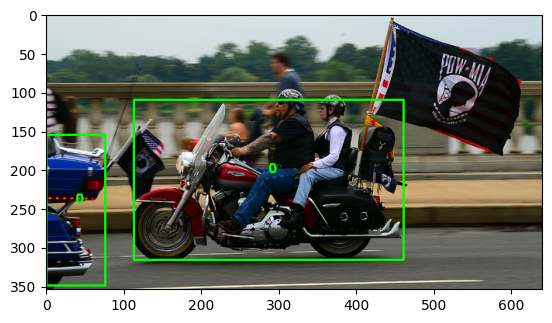

In [20]:
import cv2
import matplotlib.pyplot as plt

image_path = "/kaggle/working/labeled_images/000000492885.jpg"  # Change to a real image
label_path = image_path.replace(".jpg", ".txt")

img = cv2.imread(image_path)
h, w, _ = img.shape

with open(label_path, "r") as f:
    for line in f:
        c, x, y, bw, bh = map(float, line.split())
        x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
        cv2.rectangle(img, (x - bw // 2, y - bh // 2), (x + bw // 2, y + bh // 2), (0, 255, 0), 2)
        cv2.putText(img, str(int(c)), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

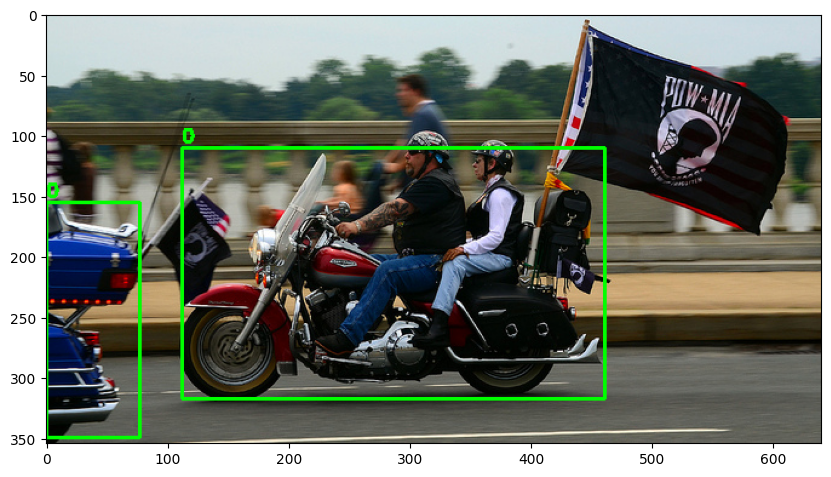

In [21]:
import cv2
import matplotlib.pyplot as plt

# Paths
image_path = "/kaggle/working/labeled_images/000000492885.jpg"  # Change this
label_path = "/kaggle/working/labeled_images/000000492885.txt"  # Change this

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib
height, width, _ = image.shape

# Read label file
with open(label_path, "r") as f:
    labels = f.readlines()

# Draw bounding boxes
for label in labels:
    class_id, x_center, y_center, w, h = map(float, label.split())

    # Convert YOLO format (normalized) to pixel coordinates
    x1 = int((x_center - w / 2) * width)
    y1 = int((y_center - h / 2) * height)
    x2 = int((x_center + w / 2) * width)
    y2 = int((y_center + h / 2) * height)

    # Draw rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, str(int(class_id)), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show image
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("on")
plt.show()

In [25]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.val(data="/kaggle/working/coco/dataset.yaml", save=True)

Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /kaggle/working/labeled_images.cache... 7319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7319/7319 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 458/458 [00:48<00:00,  9.50it/s]


                   all       7319      23251    0.00402    0.00623   0.000633   0.000162
                person       3502       8725     0.0121     0.0187    0.00184   0.000467
               bicycle       1069       1642          0          0   1.98e-05   5.23e-06
                   car       4139      12884          0          0   3.64e-05   1.34e-05


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f99b80d6ef0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [28]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Using 'n' (nano) for faster training

# Train the model
model.train(
    data="/kaggle/working/coco/dataset.yaml",
    epochs=60,
    imgsz=640,
    batch=16,
    device="cuda",
    # lr0=0.001,
    # hsv_h=0.015,  # Adjust hue (color shifts)
    # hsv_s=0.7,    # Adjust saturation (color intensity changes)
    # hsv_v=0.4,    # Adjust brightness variations
    # flipud=0.5,   # Flip images vertically (upside down)
    # fliplr=0.5,   # Flip images horizontally (mirroring)
    # mosaic=1.0,   # YOLO's built-in Mosaic augmentation (combines images)
    # mixup=0.2,    # Mixup augmentation (blends images)
    # degrees=10.0, # Random rotation (max 10 degrees)
    # translate=0.1,# Random translation (10% shift)
    # scale=0.5,    # Random scaling (up to 50% zoom in/out)
    # shear=5.0,    # Random shear (distortion)
)

Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/coco/dataset.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning /kaggle/working/labeled_images.cache... 7319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7319/7319 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/labeled_images.cache... 7319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7319/7319 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train4
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      2.15G      1.478      2.063      1.315         31        640: 100%|██████████| 458/458 [01:18<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:41<00:00,  5.58it/s]


                   all       7319      23251      0.513      0.418      0.408      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      2.19G        1.6      1.805      1.405         48        640: 100%|██████████| 458/458 [01:15<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:40<00:00,  5.69it/s]


                   all       7319      23251      0.515      0.359      0.374      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.12G      1.636      1.769      1.451         33        640: 100%|██████████| 458/458 [01:14<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:39<00:00,  5.80it/s]


                   all       7319      23251      0.496      0.375      0.375      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.14G      1.615      1.711      1.437         39        640: 100%|██████████| 458/458 [01:13<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:39<00:00,  5.87it/s]


                   all       7319      23251        0.6      0.421      0.456       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      2.07G      1.574      1.628      1.403         48        640: 100%|██████████| 458/458 [01:13<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:39<00:00,  5.82it/s]


                   all       7319      23251      0.613      0.464      0.506      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60       2.1G      1.532      1.553       1.38         34        640: 100%|██████████| 458/458 [01:14<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.93it/s]


                   all       7319      23251       0.63      0.421      0.478      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.08G      1.533      1.512      1.371         41        640: 100%|██████████| 458/458 [01:14<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.93it/s]


                   all       7319      23251      0.671      0.477      0.544      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.09G      1.496      1.462      1.347         31        640: 100%|██████████| 458/458 [01:14<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:39<00:00,  5.83it/s]


                   all       7319      23251      0.679      0.503      0.574      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60       2.1G      1.475      1.426      1.338         45        640: 100%|██████████| 458/458 [01:14<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.88it/s]


                   all       7319      23251      0.687      0.507      0.573      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.08G      1.451      1.396       1.32         32        640: 100%|██████████| 458/458 [01:14<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:39<00:00,  5.80it/s]


                   all       7319      23251      0.676      0.528      0.586      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      2.19G      1.446       1.38      1.326         30        640: 100%|██████████| 458/458 [01:14<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:39<00:00,  5.84it/s]


                   all       7319      23251      0.687      0.536        0.6      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.17G      1.427      1.351       1.31         40        640: 100%|██████████| 458/458 [01:13<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.93it/s]


                   all       7319      23251      0.702       0.52      0.591      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.09G      1.414      1.333      1.301         22        640: 100%|██████████| 458/458 [01:14<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.93it/s]


                   all       7319      23251      0.714      0.539      0.617       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      2.08G      1.403      1.306      1.291         28        640: 100%|██████████| 458/458 [01:14<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.92it/s]


                   all       7319      23251      0.712      0.546      0.623      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      2.14G      1.397      1.301      1.288         36        640: 100%|██████████| 458/458 [01:13<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.92it/s]


                   all       7319      23251      0.717      0.547       0.63      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      2.11G      1.391      1.282      1.285         39        640: 100%|██████████| 458/458 [01:14<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.91it/s]


                   all       7319      23251      0.734       0.57      0.646      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      2.06G      1.371      1.253      1.274         27        640: 100%|██████████| 458/458 [01:14<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.98it/s]


                   all       7319      23251      0.744       0.56      0.646      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      2.08G       1.37      1.242       1.27         41        640: 100%|██████████| 458/458 [01:14<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.95it/s]


                   all       7319      23251      0.758       0.57      0.659      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      2.08G      1.364      1.234      1.266         46        640: 100%|██████████| 458/458 [01:13<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.92it/s]


                   all       7319      23251      0.724      0.584      0.662      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      2.16G      1.349      1.208      1.254         30        640: 100%|██████████| 458/458 [01:14<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.96it/s]


                   all       7319      23251      0.749      0.595      0.675       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      2.11G      1.344      1.195      1.257         43        640: 100%|██████████| 458/458 [01:14<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.88it/s]


                   all       7319      23251      0.748       0.59      0.675      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      2.11G      1.337      1.183      1.255         34        640: 100%|██████████| 458/458 [01:13<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.96it/s]


                   all       7319      23251      0.764        0.6      0.686      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      2.14G      1.323      1.176      1.238         28        640: 100%|██████████| 458/458 [01:13<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.96it/s]


                   all       7319      23251      0.768      0.607      0.693      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      2.15G      1.319      1.168      1.239         31        640: 100%|██████████| 458/458 [01:13<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.98it/s]


                   all       7319      23251      0.772      0.598      0.695       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      2.09G      1.317      1.145      1.236         52        640: 100%|██████████| 458/458 [01:13<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.99it/s]


                   all       7319      23251       0.77      0.613      0.704      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      2.08G      1.308      1.138      1.228         39        640: 100%|██████████| 458/458 [01:13<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.00it/s]


                   all       7319      23251      0.771      0.628       0.71      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      2.08G      1.293      1.123      1.218         34        640: 100%|██████████| 458/458 [01:13<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.01it/s]


                   all       7319      23251      0.778       0.62      0.711       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      2.08G      1.295      1.105      1.224         23        640: 100%|██████████| 458/458 [01:13<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.98it/s]


                   all       7319      23251      0.764      0.634      0.714      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      2.08G      1.287        1.1      1.214         35        640: 100%|██████████| 458/458 [01:13<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.01it/s]


                   all       7319      23251      0.777      0.626      0.713      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      2.08G      1.278      1.087      1.213         36        640: 100%|██████████| 458/458 [01:14<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.98it/s]


                   all       7319      23251      0.799      0.632      0.728      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      2.07G       1.28      1.092      1.217         23        640: 100%|██████████| 458/458 [01:13<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.00it/s]


                   all       7319      23251      0.797      0.636      0.732      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      2.17G      1.272      1.081      1.208         27        640: 100%|██████████| 458/458 [01:13<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.97it/s]


                   all       7319      23251      0.792      0.647      0.734      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      2.06G      1.257      1.056      1.206         38        640: 100%|██████████| 458/458 [01:13<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.00it/s]


                   all       7319      23251      0.804      0.648      0.742       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      2.08G      1.256      1.047      1.197         52        640: 100%|██████████| 458/458 [01:14<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:37<00:00,  6.03it/s]


                   all       7319      23251       0.81      0.649      0.747      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      2.08G      1.256      1.046      1.195         32        640: 100%|██████████| 458/458 [01:13<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.00it/s]


                   all       7319      23251      0.807      0.654      0.749      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      2.13G      1.242      1.035      1.189         28        640: 100%|██████████| 458/458 [01:13<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.99it/s]


                   all       7319      23251      0.801      0.661       0.75       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      2.09G      1.238      1.022      1.187         45        640: 100%|██████████| 458/458 [01:13<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.97it/s]


                   all       7319      23251      0.821       0.66      0.757      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      2.09G      1.228      1.013       1.18         31        640: 100%|██████████| 458/458 [01:14<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.94it/s]


                   all       7319      23251      0.804      0.669      0.758      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      2.08G      1.229      1.011      1.182         32        640: 100%|██████████| 458/458 [01:14<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.91it/s]


                   all       7319      23251      0.811       0.67      0.761      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      2.08G      1.226          1      1.176         32        640: 100%|██████████| 458/458 [01:14<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.94it/s]


                   all       7319      23251       0.82      0.674      0.767      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      2.07G      1.219     0.9842       1.17         59        640: 100%|██████████| 458/458 [01:13<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.99it/s]


                   all       7319      23251      0.824       0.68      0.771      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      2.07G      1.217      0.975       1.17         33        640: 100%|██████████| 458/458 [01:13<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.97it/s]


                   all       7319      23251       0.82      0.686      0.774      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      2.12G      1.212     0.9696       1.17         40        640: 100%|██████████| 458/458 [01:14<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.02it/s]


                   all       7319      23251      0.819      0.691      0.777      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      2.07G      1.215     0.9719      1.165         34        640: 100%|██████████| 458/458 [01:13<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.97it/s]


                   all       7319      23251       0.83      0.683      0.778       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      2.17G      1.203     0.9596       1.16         59        640: 100%|██████████| 458/458 [01:14<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.96it/s]


                   all       7319      23251      0.825      0.693      0.782      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      2.06G      1.198     0.9505      1.163         38        640: 100%|██████████| 458/458 [01:13<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.99it/s]


                   all       7319      23251      0.833      0.695      0.785      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      2.17G      1.171     0.9263      1.151         42        640: 100%|██████████| 458/458 [01:13<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.02it/s]


                   all       7319      23251      0.842      0.692      0.788       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      2.09G       1.18     0.9348      1.149         14        640: 100%|██████████| 458/458 [01:13<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.97it/s]


                   all       7319      23251       0.84      0.697       0.79      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      2.08G      1.178     0.9209      1.145         35        640: 100%|██████████| 458/458 [01:13<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.01it/s]


                   all       7319      23251      0.841      0.708      0.795      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      2.06G      1.169     0.9164      1.142         61        640: 100%|██████████| 458/458 [01:13<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.02it/s]


                   all       7319      23251      0.843      0.703      0.795      0.569
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      2.06G      1.175     0.8881      1.123         29        640: 100%|██████████| 458/458 [01:13<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.99it/s]


                   all       7319      23251      0.843      0.697       0.79      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      2.06G      1.161     0.8559      1.116         14        640: 100%|██████████| 458/458 [01:12<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:37<00:00,  6.05it/s]


                   all       7319      23251      0.851      0.703      0.796      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      2.06G      1.153     0.8383      1.112         33        640: 100%|██████████| 458/458 [01:12<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.00it/s]


                   all       7319      23251      0.852      0.708      0.799      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      2.08G       1.15     0.8331      1.109         26        640: 100%|██████████| 458/458 [01:12<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.02it/s]


                   all       7319      23251      0.852      0.709        0.8      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      2.08G      1.141     0.8223      1.105         17        640: 100%|██████████| 458/458 [01:12<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.02it/s]


                   all       7319      23251      0.854      0.711      0.804      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      2.08G      1.134     0.8196      1.105         30        640: 100%|██████████| 458/458 [01:12<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.02it/s]


                   all       7319      23251      0.853      0.713      0.805      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      2.08G      1.133     0.8062      1.097         16        640: 100%|██████████| 458/458 [01:12<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  6.02it/s]


                   all       7319      23251      0.851      0.718      0.807      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      2.05G      1.117      0.802       1.09         12        640: 100%|██████████| 458/458 [01:12<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.99it/s]


                   all       7319      23251      0.853      0.718      0.807      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      2.08G      1.117     0.7905      1.093         28        640: 100%|██████████| 458/458 [01:12<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:37<00:00,  6.05it/s]


                   all       7319      23251      0.855      0.719      0.808      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60       2.1G      1.113       0.79      1.087         15        640: 100%|██████████| 458/458 [01:12<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:38<00:00,  5.96it/s]


                   all       7319      23251      0.852      0.724      0.809      0.587

60 epochs completed in 1.914 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 229/229 [00:41<00:00,  5.52it/s]


                   all       7319      23251      0.851      0.724      0.809      0.587
            motorcycle       3502       8725      0.875      0.748      0.847      0.613
                   bus       1069       1642      0.882      0.843      0.905      0.746
         traffic light       4139      12884      0.797      0.581      0.675      0.403


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f58dd3a9840>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

Class Distribution:
Class 0: 8725 instances
Class 1: 6069 instances
Class 2: 12884 instances


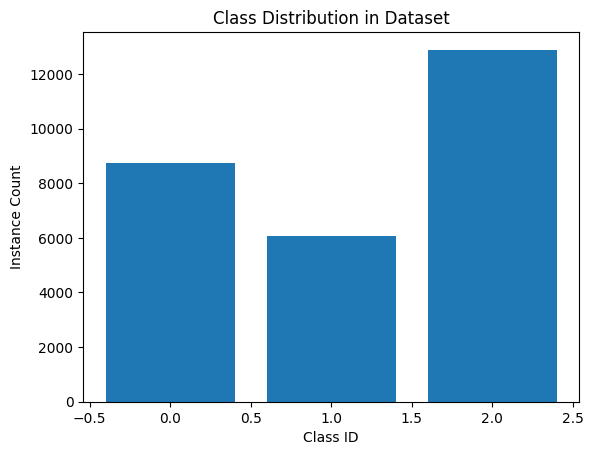

In [27]:
import os
import numpy as np
from collections import Counter

# Path to your YOLO labels folder
labels_dir = "/kaggle/working/coco/yolo_labels/"

# Count occurrences of each class
class_counts = Counter()

for file in os.listdir(labels_dir):
    if file.endswith(".txt"):
        with open(os.path.join(labels_dir, file), "r") as f:
            for line in f:
                class_id = int(line.split()[0])  # First value in YOLO label is class ID
                class_counts[class_id] += 1

# Print class counts
print("Class Distribution:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} instances")

# Plot distribution
import matplotlib.pyplot as plt

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class ID")
plt.ylabel("Instance Count")
plt.title("Class Distribution in Dataset")
plt.show()

In [29]:
from ultralytics import YOLO

# Load the original YOLOv8 model (pretrained on COCO)
model_original = YOLO("yolov8n.pt")  

# Load your trained model
model_trained = YOLO("/kaggle/working/coco/runs/detect/train4/weights/best.pt")  

In [30]:
image_path = "/kaggle/working/labeled_images/000000492885.jpg"  # Path to your test image

# Run inference using the original model
results_original = model_original(image_path, save=True)

# Run inference using the trained model
results_trained = model_trained(image_path, save=True)


image 1/1 /kaggle/working/labeled_images/000000492885.jpg: 384x640 4 persons, 4 motorcycles, 42.0ms
Speed: 1.1ms preprocess, 42.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict

image 1/1 /kaggle/working/labeled_images/000000492885.jpg: 384x640 2 motorcycles, 8.6ms
Speed: 1.0ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2


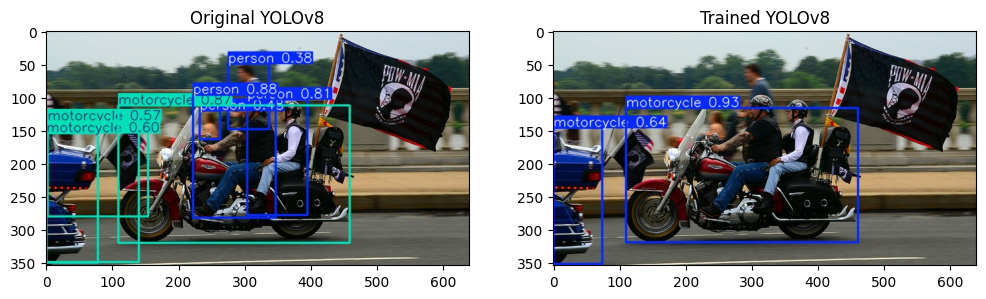

In [31]:
import cv2
import matplotlib.pyplot as plt

# Load results
img_original = cv2.imread("/kaggle/working/coco/runs/detect/predict/000000492885.jpg")  # Path where YOLO saves results
img_trained = cv2.imread("/kaggle/working/coco/runs/detect/predict2/000000492885.jpg")  # Second inference result

# Convert BGR to RGB for Matplotlib
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_trained = cv2.cvtColor(img_trained, cv2.COLOR_BGR2RGB)

# Display images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_original)
axes[0].set_title("Original YOLOv8")
axes[1].imshow(img_trained)
axes[1].set_title("Trained YOLOv8")
plt.show()

In [32]:
# Validate original model on dataset
metrics_original = model_original.val(data="dataset.yaml")

# Validate trained model
metrics_trained = model_trained.val(data="dataset.yaml")

# Print mAP50 for both models
print(f"Original mAP50: {metrics_original.box.map50}")
print(f"Trained mAP50: {metrics_trained.box.map50}")

Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/labeled_images.cache... 7319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7319/7319 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 458/458 [00:51<00:00,  8.88it/s]


                   all       7319      23251    0.00879      0.025    0.00298   0.000979
                person       3502       8725     0.0254     0.0742    0.00835    0.00268
               bicycle       1069       1642   0.000648   0.000609   2.99e-05   1.66e-05
                   car       4139      12884   0.000286    0.00031   0.000543    0.00024


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/labeled_images.cache... 7319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7319/7319 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 458/458 [00:48<00:00,  9.44it/s]


                   all       7319      23251      0.852      0.724      0.809      0.588
            motorcycle       3502       8725      0.875      0.747      0.847      0.614
                   bus       1069       1642      0.881      0.843      0.904      0.746
         traffic light       4139      12884      0.799      0.581      0.676      0.405


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val2
Original mAP50: 0.0029756905033196325
Trained mAP50: 0.809233524465352


In [43]:
print("Original Model Class Mapping:", metrics_original.names)
print("Trained Model Class Mapping:", metrics_trained.names)

Original Model Class Mapping: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard',

In [49]:
import torch

def detect_and_compare(model, img_path, class_mapping):
    """
    Runs inference on an image using the given model and prints the detected objects 
    with their confidence scores.

    Args:
    - model: The YOLO model (either original or trained).
    - img_path: Path to the image for inference.
    - class_mapping: Dictionary mapping class IDs to class names.
    """
    results = model(img_path)  # Run inference
    detections = results[0].boxes  # YOLOv8 stores results in `boxes`

    print("\nDetected Objects:")
    for det in detections:
        class_id, confidence = int(det.cls.item()), det.conf.item()  # Get class ID & confidence
        class_name = class_mapping.get(class_id, "Unknown")
        print(f"{class_name}: {confidence:.2%}")  # Convert to percentage

# ✅ Run inference on an image for both models
img_path = "/kaggle/working/labeled_images/000000492885.jpg"  # Change this to your actual image path

# ✅ Detect objects with Original Model
print("🔹 Original Model Detection:")
detect_and_compare(model_original, img_path, metrics_original.names)

# ✅ Detect objects with Trained Model
print("\n🔹 Trained Model Detection:")
detect_and_compare(model_trained, img_path, metrics_trained.names)

🔹 Original Model Detection:

image 1/1 /kaggle/working/labeled_images/000000492885.jpg: 384x640 4 persons, 4 motorcycles, 10.4ms
Speed: 1.5ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

Detected Objects:
person: 88.49%
motorcycle: 86.87%
person: 81.16%
motorcycle: 60.07%
motorcycle: 57.26%
person: 48.01%
person: 38.40%
motorcycle: 32.99%

🔹 Trained Model Detection:

image 1/1 /kaggle/working/labeled_images/000000492885.jpg: 384x640 2 motorcycles, 6.6ms
Speed: 0.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

Detected Objects:
motorcycle: 93.00%
motorcycle: 63.96%


In [50]:
!ls /kaggle/working/labeled_images | head -10

000000000073.jpg
000000000073.txt
000000000086.jpg
000000000086.txt
000000000257.jpg
000000000257.txt
000000000260.txt
000000000359.jpg
000000000359.txt
000000000471.txt
ls: write error: Broken pipe


In [51]:
import torch

def detect_and_compare(model, img_path, class_mapping):
    """
    Runs inference on an image using the given model and prints the detected objects 
    with their confidence scores.

    Args:
    - model: The YOLO model (either original or trained).
    - img_path: Path to the image for inference.
    - class_mapping: Dictionary mapping class IDs to class names.
    """
    results = model(img_path)  # Run inference
    detections = results[0].boxes  # YOLOv8 stores results in `boxes`

    print("\nDetected Objects:")
    for det in detections:
        class_id, confidence = int(det.cls.item()), det.conf.item()  # Get class ID & confidence
        class_name = class_mapping.get(class_id, "Unknown")
        print(f"{class_name}: {confidence:.2%}")  # Convert to percentage

# ✅ Run inference on an image for both models
img_path = "/kaggle/working/labeled_images/000000000073.jpg"  # Change this to your actual image path

# ✅ Detect objects with Original Model
print("🔹 Original Model Detection:")
detect_and_compare(model_original, img_path, metrics_original.names)

# ✅ Detect objects with Trained Model
print("\n🔹 Trained Model Detection:")
detect_and_compare(model_trained, img_path, metrics_trained.names)

🔹 Original Model Detection:

image 1/1 /kaggle/working/labeled_images/000000000073.jpg: 640x576 1 motorcycle, 55.3ms
Speed: 2.4ms preprocess, 55.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)

Detected Objects:
motorcycle: 82.57%

🔹 Trained Model Detection:

image 1/1 /kaggle/working/labeled_images/000000000073.jpg: 640x576 3 motorcycles, 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

Detected Objects:
motorcycle: 85.23%
motorcycle: 68.74%
motorcycle: 34.51%



image 1/1 /kaggle/working/labeled_images/000000000073.jpg: 640x576 1 motorcycle, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)
Results saved to /kaggle/working/coco/runs/detect/predict_original

image 1/1 /kaggle/working/labeled_images/000000000073.jpg: 640x576 3 motorcycles, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)
Results saved to /kaggle/working/coco/runs/detect/predict_trained


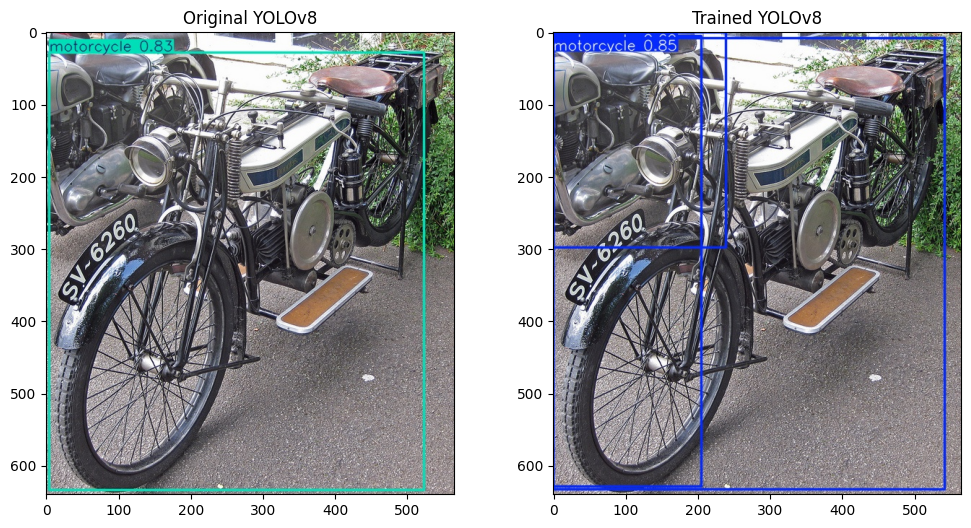

In [55]:
import cv2
import matplotlib.pyplot as plt

image_path = "/kaggle/working/labeled_images/000000000073.jpg"  # Path to your test image

# ✅ Run inference using the original model and save to "predict_original"
results_original = model_original(image_path, save=True, project="/kaggle/working/coco/runs/detect", name="predict_original")

# ✅ Run inference using the trained model and save to "predict_trained"
results_trained = model_trained(image_path, save=True, project="/kaggle/working/coco/runs/detect", name="predict_trained")

# ✅ Load results separately
img_original = cv2.imread("/kaggle/working/coco/runs/detect/predict_original/000000000073.jpg")
img_trained = cv2.imread("/kaggle/working/coco/runs/detect/predict_trained/000000000073.jpg")

# Convert BGR to RGB for Matplotlib
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_trained = cv2.cvtColor(img_trained, cv2.COLOR_BGR2RGB)

# Display images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_original)
axes[0].set_title("Original YOLOv8")
axes[1].imshow(img_trained)
axes[1].set_title("Trained YOLOv8")
plt.show()

In [59]:
import torch

def detect_and_compare(model, img_path, class_mapping):
    """
    Runs inference on an image using the given model and prints the detected objects 
    with their confidence scores.

    Args:
    - model: The YOLO model (either original or trained).
    - img_path: Path to the image for inference.
    - class_mapping: Dictionary mapping class IDs to class names.
    """
    results = model(img_path)  # Run inference
    detections = results[0].boxes  # YOLOv8 stores results in `boxes`

    print("\nDetected Objects:")
    for det in detections:
        class_id, confidence = int(det.cls.item()), det.conf.item()  # Get class ID & confidence
        class_name = class_mapping.get(class_id, "Unknown")
        print(f"{class_name}: {confidence:.2%}")  # Convert to percentage

# ✅ Run inference on an image for both models
img_path = "/kaggle/working/labeled_images/000000000359.jpg"  # Change this to your actual image path

# ✅ Detect objects with Original Model
print("🔹 Original Model Detection:")
detect_and_compare(model_original, img_path, metrics_original.names)

# ✅ Detect objects with Trained Model
print("\n🔹 Trained Model Detection:")
detect_and_compare(model_trained, img_path, metrics_trained.names)

🔹 Original Model Detection:

image 1/1 /kaggle/working/labeled_images/000000000359.jpg: 448x640 1 car, 2 traffic lights, 47.0ms
Speed: 2.2ms preprocess, 47.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

Detected Objects:
traffic light: 65.08%
traffic light: 54.40%
car: 45.46%

🔹 Trained Model Detection:

image 1/1 /kaggle/working/labeled_images/000000000359.jpg: 448x640 2 traffic lights, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

Detected Objects:
traffic light: 81.58%
traffic light: 74.33%



image 1/1 /kaggle/working/labeled_images/000000000359.jpg: 448x640 1 car, 2 traffic lights, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /kaggle/working/coco/runs/detect/predict_original3

image 1/1 /kaggle/working/labeled_images/000000000359.jpg: 448x640 2 traffic lights, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /kaggle/working/coco/runs/detect/predict_trained3


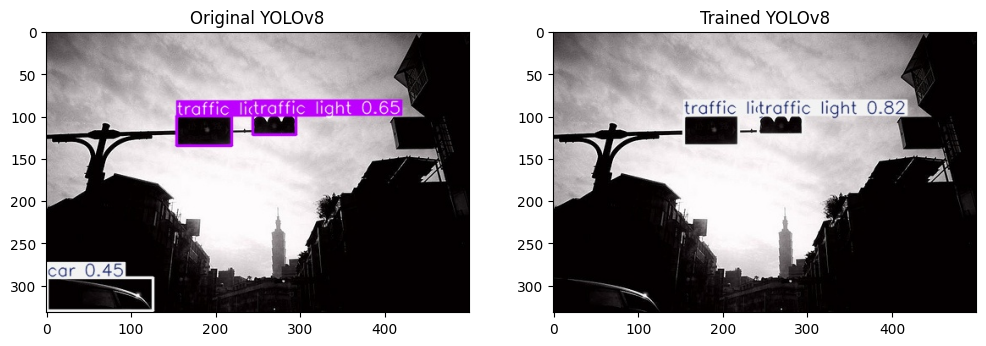

In [61]:
import cv2
import matplotlib.pyplot as plt

image_path = "/kaggle/working/labeled_images/000000000359.jpg"  # Path to your test image

# ✅ Run inference using the original model and save to "predict_original"
results_original = model_original(image_path, save=True, project="/kaggle/working/coco/runs/detect", name="predict_original")

# ✅ Run inference using the trained model and save to "predict_trained"
results_trained = model_trained(image_path, save=True, project="/kaggle/working/coco/runs/detect", name="predict_trained")

# ✅ Load results separately
img_original = cv2.imread("/kaggle/working/coco/runs/detect/predict_original2/000000000359.jpg")
img_trained = cv2.imread("/kaggle/working/coco/runs/detect/predict_trained2/000000000359.jpg")

# Convert BGR to RGB for Matplotlib
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_trained = cv2.cvtColor(img_trained, cv2.COLOR_BGR2RGB)

# Display images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_original)
axes[0].set_title("Original YOLOv8")
axes[1].imshow(img_trained)
axes[1].set_title("Trained YOLOv8")
plt.show()